In [217]:
import pymysql
import pandas as pd

def get_connection():
    conn = pymysql.connect(
        host="127.0.0.1",
        user="root",
        password="Ekdzhddl!",
        database="olist",
    )
    return conn

In [218]:
def read_data(sql):
    with conn.cursor() as cursor:
        cursor.execute(read_sql)
        result = cursor.fetchall()
    print(f"total items: {len(result)}")
    for i, item in enumerate(result):
        if i > 10:
            break
        print(item)
    return result

In [219]:
conn = get_connection()

데이터 전처리 과정
1. products 데이터의 제품 카테고리 정보가 있으나, category_translation 데이터에는 누락 된 정보들을 추가.
   - portateis_cozinha_e_preparadores_de_alimentos, pc_gamer
2. products 내 product_category_name 데이터의 NULL 값은 products 테이블 데이터의 1.85% 였음. soft delete 처리.

In [55]:
# 상품 카테고리 별 평균 평점을 집계해보세요.
read_sql = """
WITH one_step AS (
SELECT 
	p.product_id,
	p.product_category_name,
    c.product_category_name_english,
	o.order_id
FROM
	products p
LEFT JOIN
	order_items o
ON
	p.product_id = o.product_id
    
LEFT JOIN
	category_name_translation c
ON
	p.product_category_name=c.product_category_name
    
WHERE
	p.deleted = False
)
SELECT
    AVG(r.review_score) AS avg_review_score,
    os.product_category_name_english
FROM
    reviews r
    
LEFT JOIN
    one_step os
ON
    r.order_id = os.order_id
    
GROUP BY
    os.product_category_name
ORDER BY
	avg_review_score DESC
"""

product_category_name's total count is 73
전체 판매 '112650' 중 '1603'건의 NULL 값이 발생, 전체 판매의 1.42% 임으로 Soft delete 함.

In [56]:
result_df = pd.read_sql(read_sql,conn)

/var/folders/ly/7phrswwd4gzcgyt5t5p35nqw0000gn/T/ipykernel_49079/4254694705.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result_df = pd.read_sql(read_sql,conn)


In [57]:
result_df

,avg_review_score,product_category_name_english
0,4.6429,cds_dvds_musicals
1,4.5000,fashion_childrens_clothes
2,4.4463,books_general_interest
3,4.4444,costruction_tools_tools
4,4.4194,flowers
...,...,...
69,3.3333,pc_gamer
70,3.2667,portable kitchen food preparers
71,3.2564,diapers_and_hygiene
72,3.1699,None


In [59]:
result_df.set_index("avg_review_score")

,product_category_name_english
avg_review_score,
4.6429,cds_dvds_musicals
4.5000,fashion_childrens_clothes
4.4463,books_general_interest
4.4444,costruction_tools_tools
4.4194,flowers
...,...
3.3333,pc_gamer
3.2667,portable kitchen food preparers
3.2564,diapers_and_hygiene


In [62]:
df_masked = result_df.fillna('Unknown')

In [64]:
df_masked

,avg_review_score,product_category_name_english
0,4.6429,cds_dvds_musicals
1,4.5000,fashion_childrens_clothes
2,4.4463,books_general_interest
3,4.4444,costruction_tools_tools
4,4.4194,flowers
...,...,...
69,3.3333,pc_gamer
70,3.2667,portable kitchen food preparers
71,3.2564,diapers_and_hygiene
72,3.1699,Unknown


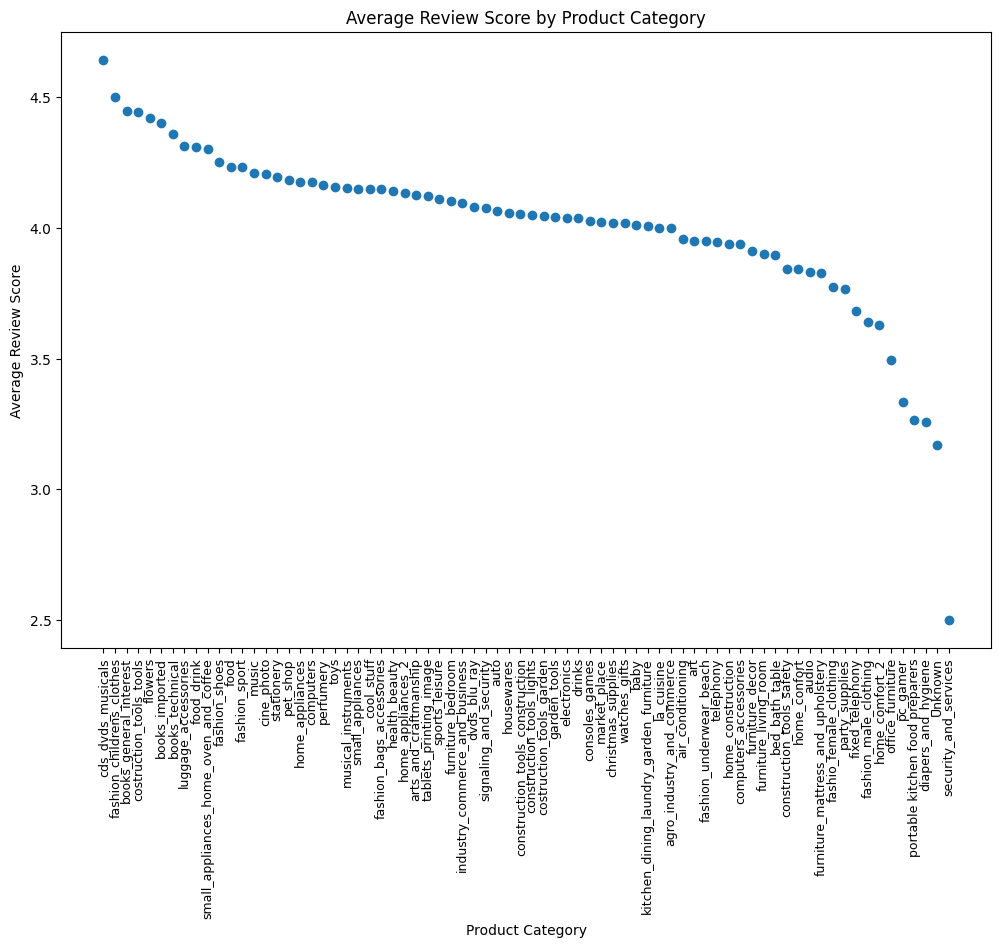

In [65]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 8))
plt.scatter(df_masked['product_category_name_english'], df_masked['avg_review_score'])
plt.xlabel('Product Category')
plt.ylabel('Average Review Score')
plt.title('Average Review Score by Product Category')
_=plt.xticks(size=9,rotation=90)

In [66]:
# 매출이 가장 높은 상품 상위 카테고리 10개를 집계해보세요.
read_sql = """
WITH products_info_english AS (
SELECT 
	p.product_id,
	c.product_category_name_english
FROM 
	products p
LEFT JOIN
	category_name_translation c
ON
	p.product_category_name=c.product_category_name
)
SELECT
	SUM(oi.price * oi.order_item_id) AS total_sales,
    pie.product_category_name_english
FROM
	order_items oi
    
LEFT JOIN
	products_info_english pie
ON 
	oi.product_id=pie.product_id
GROUP BY
	pie.product_category_name_english    
ORDER BY
	SUM(oi.price*oi.order_item_id) DESC
LIMIT 10;
"""

In [67]:
result_df = pd.read_sql(read_sql,conn)

/var/folders/ly/7phrswwd4gzcgyt5t5p35nqw0000gn/T/ipykernel_49079/4254694705.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result_df = pd.read_sql(read_sql,conn)


In [68]:
# total_sales를 FORMAT을 씌우면 String으로 변하면서, 시각화에 문제가 생김...
result_df

,total_sales,product_category_name_english
0,1.347468e+06,health_beauty
1,1.259635e+06,watches_gifts
2,1.228795e+06,bed_bath_table
3,1.135455e+06,computers_accessories
4,1.082435e+06,sports_leisure
5,9.295210e+05,furniture_decor
6,7.502337e+05,housewares
7,6.628619e+05,auto
8,6.595906e+05,cool_stuff
9,5.841550e+05,garden_tools


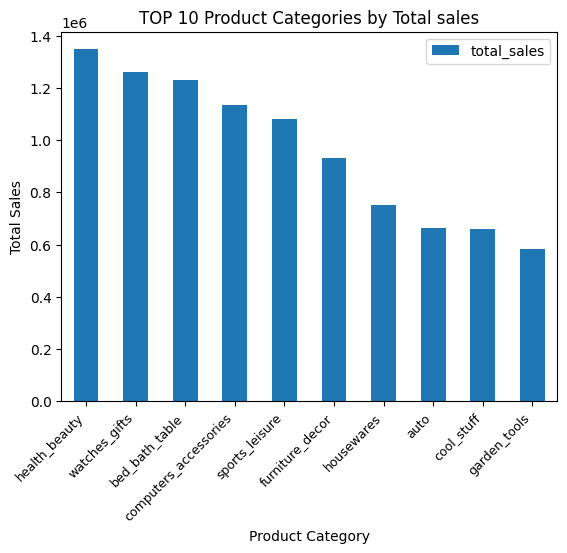

In [69]:
from matplotlib import pyplot as plt
result_df.set_index("product_category_name_english").plot(kind="bar")# 뒤에 이렇게 넣고싶은데 안됑..,label="sales"
# plt.legend()
plt.title("TOP 10 Product Categories by Total sales")
plt.xlabel("Product Category")
plt.ylabel("Total Sales")

_=plt.xticks(size=9, rotation=45, ha="right")

In [70]:
# 각 카테고리별로 월별 매출 추이를 시각화해보세요. (sql과 python 이용)

In [277]:
read_sql ="""
WITH one_step AS (
SELECT 
	p.product_id,
	p.product_category_name,
    c.product_category_name_english,
	o.order_id,
    o.order_item_id,
    o.price
FROM
	products p
LEFT JOIN
	order_items o
ON
	p.product_id = o.product_id
LEFT JOIN
	category_name_translation c
ON
	p.product_category_name=c.product_category_name
    
WHERE
	p.deleted = False
)
SELECT
	SUM(os.price * os.order_item_id) AS total_sales,
    DATE_FORMAT(orders.order_purchase_timestamp, '%Y-%m') AS month,
    os.product_category_name_english
FROM
	one_step os

LEFT JOIN
	orders
ON 
	orders.order_id=os.order_id

GROUP BY
	month, os.product_category_name_english

ORDER BY
	month
    
"""

In [278]:
result_df = pd.read_sql(read_sql,conn)

/var/folders/ly/7phrswwd4gzcgyt5t5p35nqw0000gn/T/ipykernel_49079/4254694705.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result_df = pd.read_sql(read_sql,conn)


In [279]:
result_df

,total_sales,month,product_category_name_english
0,105.790005,2016-09,furniture_decor
1,269.940010,2016-09,health_beauty
2,59.500000,2016-09,telephony
3,2935.289886,2016-10,air_conditioning
4,156.990000,2016-10,audio
...,...,...,...
1257,16085.629903,2018-08,stationery
1258,48779.029930,2018-08,telephony
1259,20884.540066,2018-08,toys
1260,74860.309881,2018-08,watches_gifts


In [280]:
pivot_df

product_category_name_english,air_conditioning,audio,auto,baby,bed_bath_table,books_general_interest,books_technical,furniture_decor,health_beauty,telephony
month,,,,,,,,,,
2016-09-01,0.000000,0.00,0.000000,0.00000,0.00,0.0,0.0,105.790005,269.94001,59.5
2016-10-01,2935.289886,156.99,2028.249983,1829.95001,757.77,119.5,267.0,0.000000,0.00000,0.0


In [281]:
result_df['month'] = pd.to_datetime(result_df['month'], errors='coerce')

In [282]:
pivot_df = result_df.pivot_table(index='month', columns='product_category_name_english', values='total_sales')
pivot_df = pivot_df.fillna(0)

/var/folders/ly/7phrswwd4gzcgyt5t5p35nqw0000gn/T/ipykernel_49079/3937305777.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


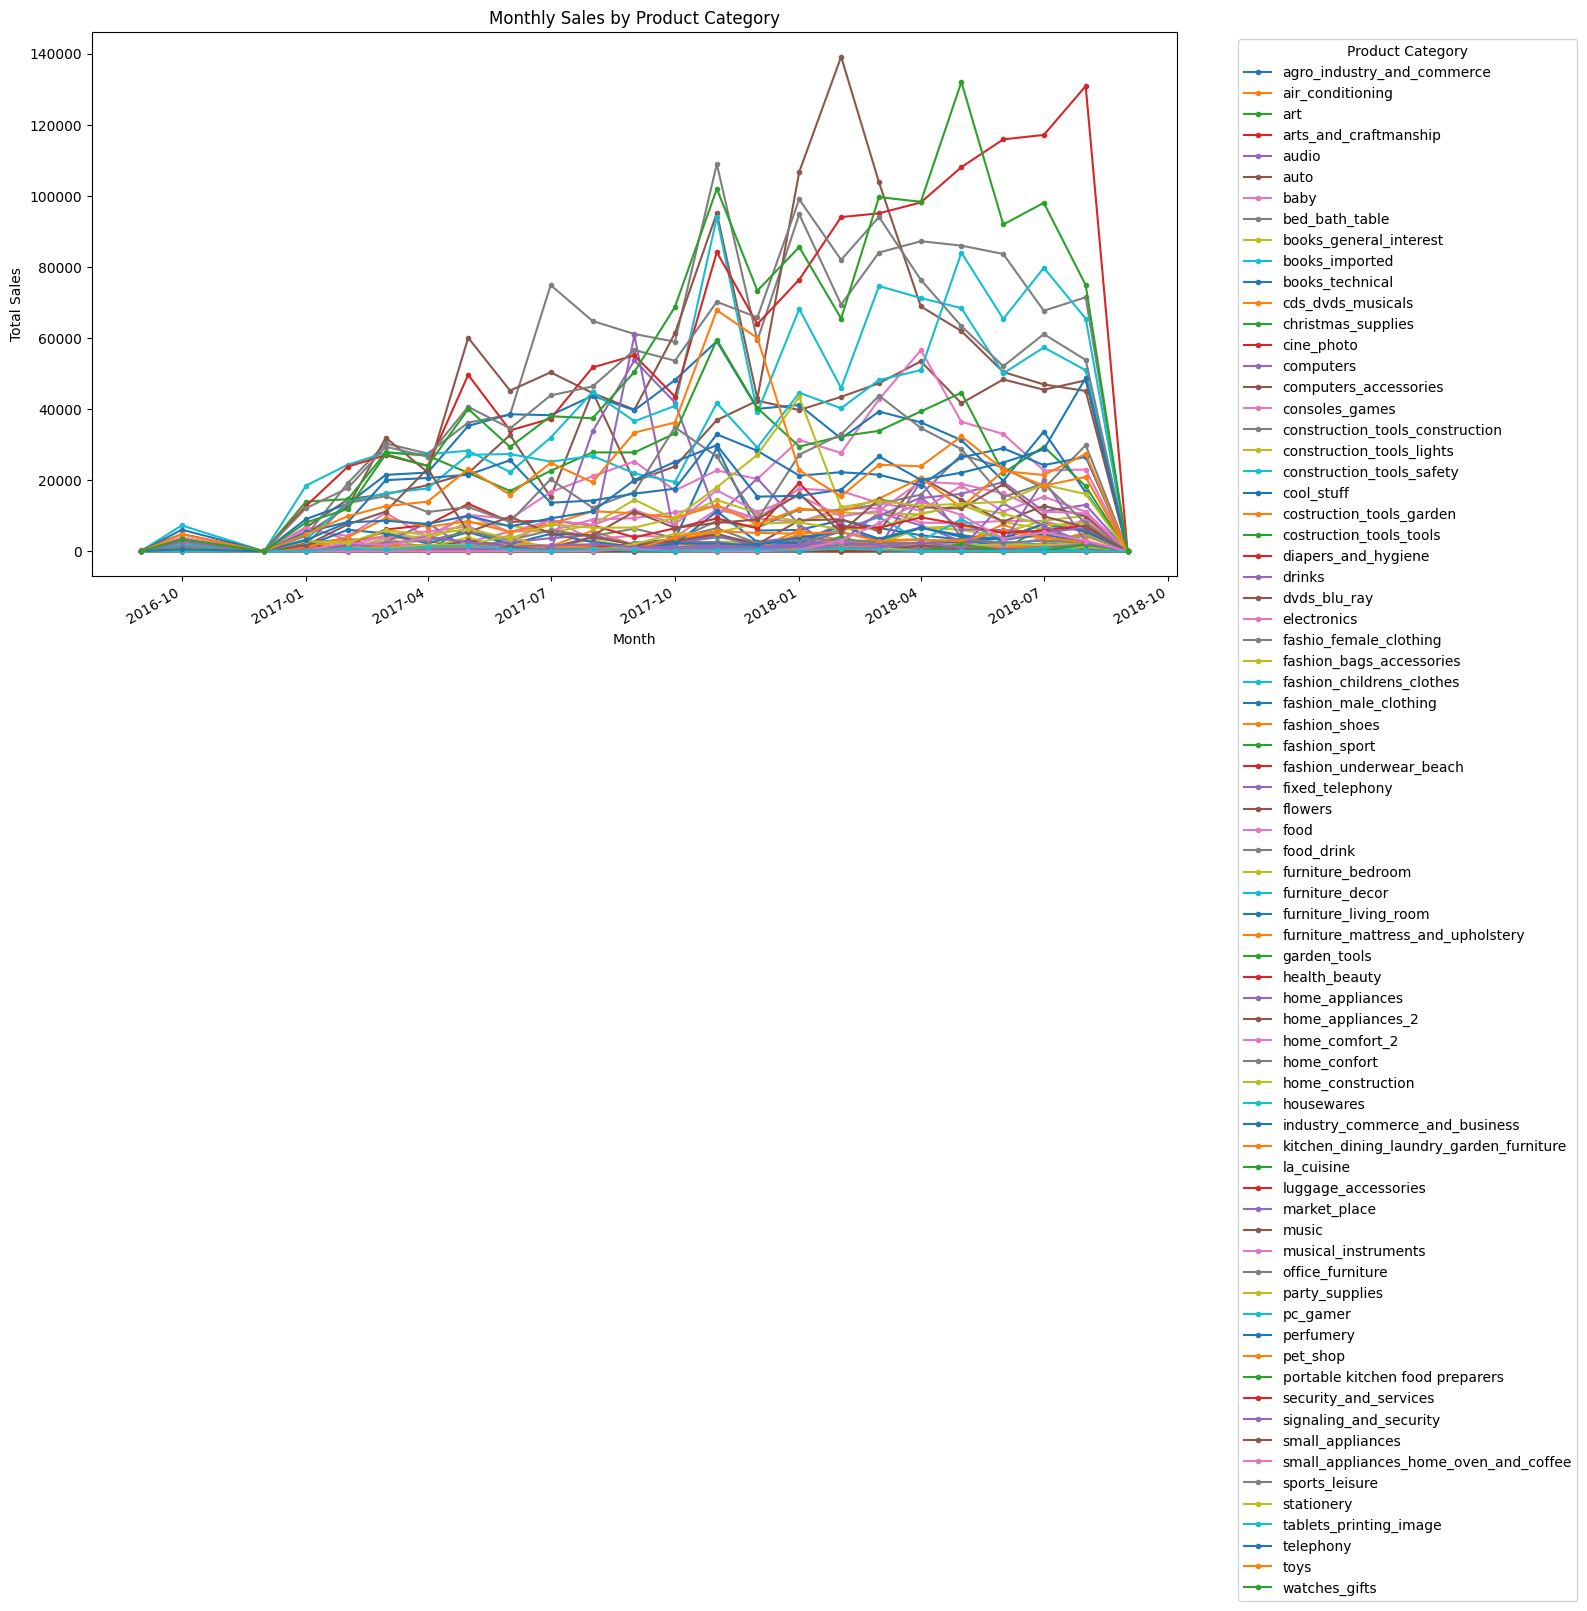

In [283]:
pivot_df.plot(kind='line', figsize=(14, 8),marker = "o", markersize = 3)
plt.title('Monthly Sales by Product Category')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# 1. 기본적인 특징을 파악할 것 (EDA)
# - 일자별 매출 추이
# - 카테고리별 매출 추이
# - 지역별 매출추이
# - 지불 수단별 매출추이
# - 매출이 많이 일어나는 품목
# - 구매를 많이 하는 지역
# …
# -> 뻔한 데이터를 뽑아보는 것

# 2. 뻔한 데이터 속 특이한 패턴 찾기
# - 유달리 매출이 급증한 기간
# - 유달리 매출이 잘나오는 지역
# - 유달리 환불이 잘일어나는 상황
# - 유달리 지불 금액이 큰 지불 수단
# …

# 3. 특이한 패턴에서 꼬리물기
# - 세부적인 쿼리 작성
# - 좀 더 디테일한 가설 설정

# 4. 가설 세우기
# - 아! 혹시 특정 카테고리가 인기가 많은 지역이 있지 않을까? 정말 그럴까?

# 5. 가설을 입증할 수 있는 쿼리 작성

In [340]:
#연간 매출 쿼리
read_sql = """
SELECT
    SUM(order_items.price * order_items.order_item_id) AS total_sales,
    DATE_FORMAT(orders.order_approved_at, '%Y') AS year
FROM
    order_items
LEFT JOIN
    orders
ON 
    orders.order_id = order_items.order_id
WHERE
    orders.order_approved_at IS NOT NULL
GROUP BY
    year
ORDER BY
    year

"""

In [341]:
year_sales_df = pd.read_sql(read_sql,conn)

/var/folders/ly/7phrswwd4gzcgyt5t5p35nqw0000gn/T/ipykernel_1326/2678143009.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  year_sales_df = pd.read_sql(read_sql,conn)


In [342]:
year_sales_df.set_index("year")

,total_sales
year,
2016,5.654992e+04
2017,6.971842e+06
2018,8.367627e+06


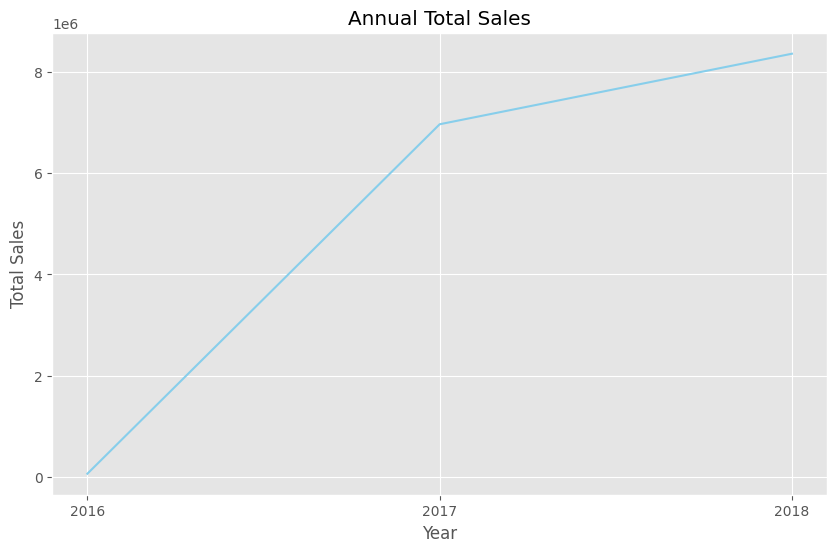

In [347]:
plt.figure(figsize=(10, 6))
plt.plot(year_sales_df['year'], year_sales_df['total_sales'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Annual Total Sales')
plt.show()

In [330]:
plt.plot(year_sales_df.loc["year"])

KeyError: 'year'

In [21]:
# 도시별 고객점유율 

read_sql= """
WITH customer_counts AS (
    SELECT 
        customer_city,
        customer_state,
        COUNT(*) AS customer_count,
        COUNT(*) * 1.0 / SUM(COUNT(*)) OVER () AS percentage
    FROM 
        olist.customers
    GROUP BY
        customer_city,
        customer_state
)
SELECT 
    customer_city,
    customer_state,
    customer_count,
    percentage * 100 AS percentage
FROM 
    customer_counts
    
WHERE
    customer_count > 100
    
ORDER BY
    customer_count DESC

"""

In [22]:
customer_cityloc_df = pd.read_sql(read_sql,conn)

/var/folders/ly/7phrswwd4gzcgyt5t5p35nqw0000gn/T/ipykernel_1326/4229074069.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  customer_cityloc_df = pd.read_sql(read_sql,conn)


In [23]:
# 0.1% 미만 100명 이하 지역은 배제하였음. 
customer_cityloc_df.set_index("customer_city")

,customer_state,customer_count,percentage
customer_city,,,
sao paulo,SP,15540,15.627
rio de janeiro,RJ,6882,6.921
belo horizonte,MG,2773,2.789
brasilia,DF,2131,2.143
curitiba,PR,1521,1.530
...,...,...,...
caieiras,SP,102,0.103
botucatu,SP,101,0.102
pindamonhangaba,SP,101,0.102


/var/folders/ly/7phrswwd4gzcgyt5t5p35nqw0000gn/T/ipykernel_1326/3024588438.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(customer_cityloc_df["customer_count"],labels=["customers"])


{'whiskers': [<matplotlib.lines.Line2D at 0x10fae4650>,
 'caps': [<matplotlib.lines.Line2D at 0x10fae4bf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x10fae4410>],
 'medians': [<matplotlib.lines.Line2D at 0x10fae52e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x10fae5820>],
 'means': []}

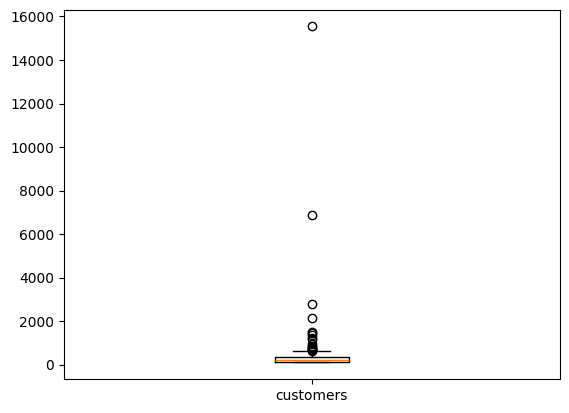

In [24]:
from matplotlib import pyplot as plt

plt.boxplot(customer_cityloc_df["customer_count"],labels=["customers"])

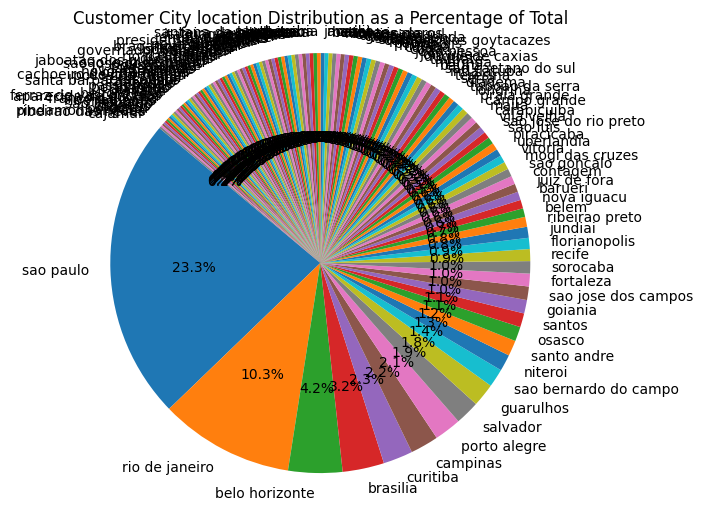

In [25]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8, 6))
plt.pie(customer_cityloc_df['percentage'], labels=customer_cityloc_df['customer_city'], autopct='%1.1f%%', startangle=140)
plt.title('Customer City location Distribution as a Percentage of Total')
plt.axis('equal')
plt.show()

In [28]:
# 주별 고객점유율 
read_sql= """
WITH customer_counts AS (
    SELECT 
        customer_state,
        COUNT(*) AS customer_count,
        COUNT(*) * 1.0 / SUM(COUNT(*)) OVER () AS percentage
    FROM 
        olist.customers
    GROUP BY
        customer_state
)
SELECT 
    customer_state,
    customer_count,
    percentage * 100 AS percentage
FROM 
    customer_counts
    
WHERE
    customer_count > 100
    
ORDER BY
    customer_count DESC

"""

In [29]:
customer_stateloc_df = pd.read_sql(read_sql,conn)

/var/folders/ly/7phrswwd4gzcgyt5t5p35nqw0000gn/T/ipykernel_1326/705598019.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  customer_stateloc_df = pd.read_sql(read_sql,conn)


In [31]:
customer_stateloc_df.set_index("customer_state")

,customer_count,percentage
customer_state,,
SP,41746,41.981
RJ,12852,12.924
MG,11635,11.700
RS,5466,5.497
PR,5045,5.073
SC,3637,3.657
BA,3380,3.399
DF,2140,2.152
ES,2033,2.044


/var/folders/ly/7phrswwd4gzcgyt5t5p35nqw0000gn/T/ipykernel_1326/2430739520.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(customer_stateloc_df["customer_count"],labels=["customers"])


{'whiskers': [<matplotlib.lines.Line2D at 0x10f91a8a0>,
 'caps': [<matplotlib.lines.Line2D at 0x10f7c7ef0>,
 'boxes': [<matplotlib.lines.Line2D at 0x10f7c7440>],
 'medians': [<matplotlib.lines.Line2D at 0x10f7c59a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x10f7c6d80>],
 'means': []}

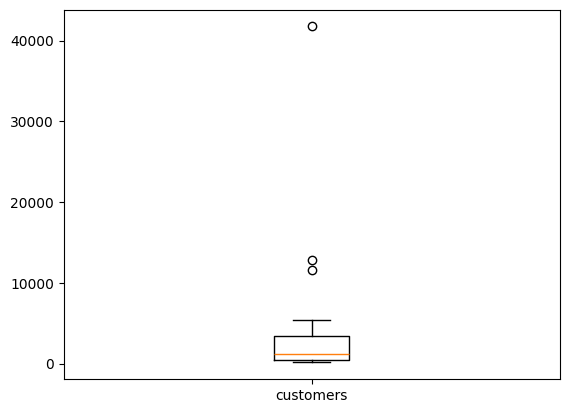

In [32]:
from matplotlib import pyplot as plt

plt.boxplot(customer_stateloc_df["customer_count"],labels=["customers"])

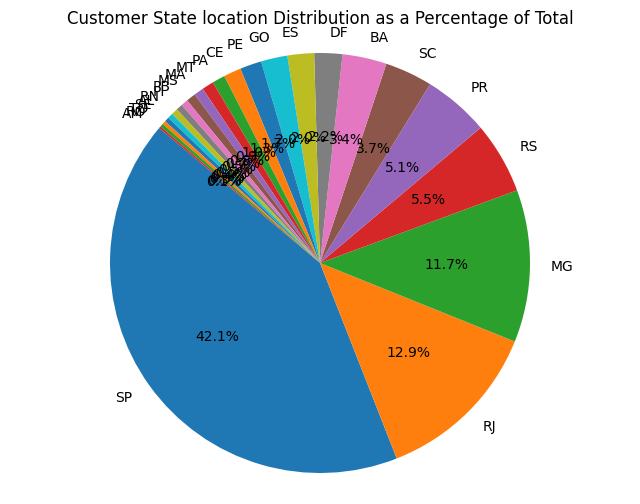

In [38]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8, 6))
plt.pie(customer_stateloc_df['percentage'], labels=customer_stateloc_df['customer_state'], autopct='%1.1f%%', startangle=140)
plt.title('Customer State location Distribution as a Percentage of Total')
plt.axis('equal')
plt.show()

In [56]:
# 셀러들의 도시분포
read_sql="""
WITH seller_counts AS(
    SELECT 
        seller_city,
        seller_state,
        COUNT(*) AS seller_count,
        COUNT(*) * 1.0 / SUM(COUNT(*)) OVER () AS percentage
    
    FROM 
    	sellers
    GROUP BY
        seller_city,
        seller_state
)
SELECT
    seller_city,
    seller_state,
    seller_count,
    percentage * 100 AS percentage
FROM
    seller_counts
    
ORDER BY
	seller_count DESC

"""

In [57]:
seller_cityloc_df = pd.read_sql(read_sql,conn)

/var/folders/ly/7phrswwd4gzcgyt5t5p35nqw0000gn/T/ipykernel_1326/1363052358.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  seller_cityloc_df = pd.read_sql(read_sql,conn)


In [58]:
seller_cityloc_df.set_index("seller_count")

,seller_city,seller_state,percentage
seller_count,,,
695,sao paulo,SP,22.456
124,curitiba,PR,4.006
93,rio de janeiro,RJ,3.005
66,belo horizonte,MG,2.132
52,ribeirao preto,SP,1.680
...,...,...,...
1,caratinga,MG,0.032
1,marica,RJ,0.032
1,barbacena/ minas gerais,MG,0.032


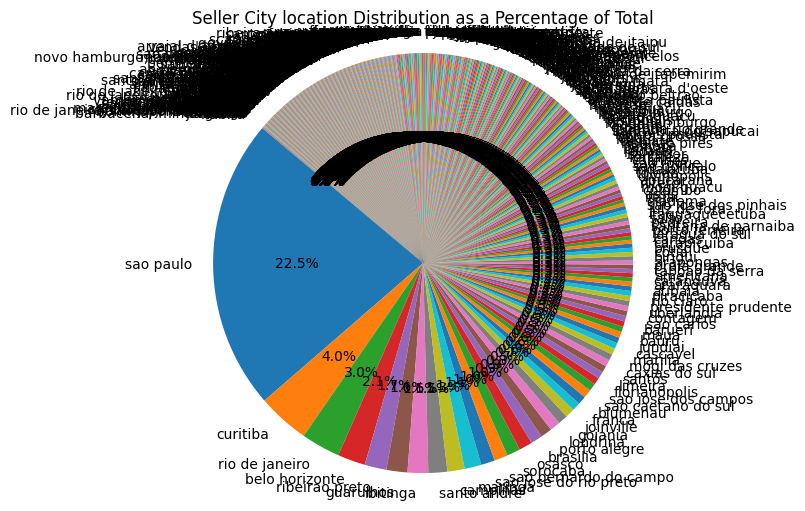

In [49]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8, 6))
plt.pie(seller_cityloc_df['percentage'], labels=seller_cityloc_df['seller_city'], autopct='%1.1f%%', startangle=140)
plt.title('Seller City location Distribution as a Percentage of Total')
plt.axis('equal')
plt.show()

In [50]:
# 셀러들의 주 분포
read_sql="""
WITH seller_counts AS(
    SELECT 
        seller_state,
        COUNT(*) AS seller_count,
        COUNT(*) * 1.0 / SUM(COUNT(*)) OVER () AS percentage
    
    FROM 
    	sellers
    GROUP BY
        seller_state
)
SELECT
    seller_state,
    seller_count,
    percentage * 100 AS percentage
FROM
    seller_counts
    
ORDER BY
	seller_count DESC

"""

In [51]:
seller_stateloc_df = pd.read_sql(read_sql,conn)

/var/folders/ly/7phrswwd4gzcgyt5t5p35nqw0000gn/T/ipykernel_1326/3381715496.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  seller_stateloc_df = pd.read_sql(read_sql,conn)


In [52]:
seller_stateloc_df.set_index("seller_count")

,seller_state,percentage
seller_count,,
1849,SP,59.742
349,PR,11.276
244,MG,7.884
190,SC,6.139
171,RJ,5.525
129,RS,4.168
40,GO,1.292
30,DF,0.969
23,ES,0.743


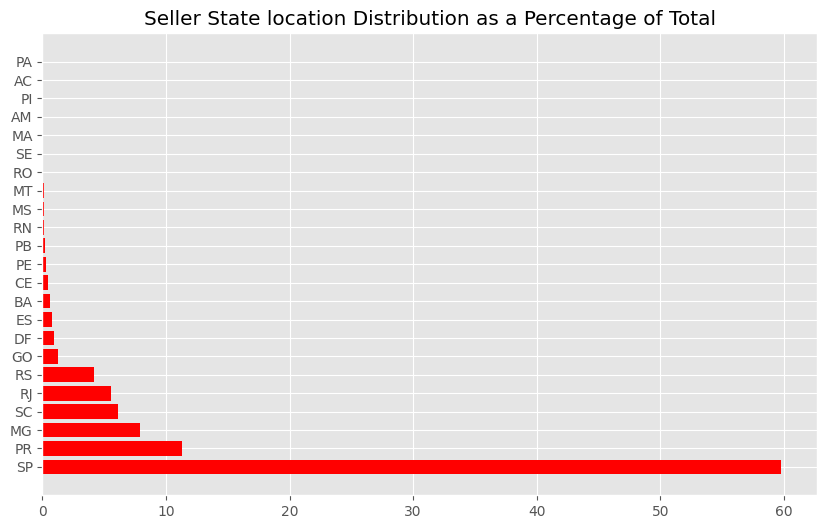

In [129]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(seller_stateloc_df['seller_state'],seller_stateloc_df['percentage'], color='red',)
plt.title('Seller State location Distribution as a Percentage of Total')
plt.show()

In [243]:
# Olist 매출 상위 지역
read_sql = """
WITH onedep AS(
	SELECT 
		order_items.order_item_id,
		order_items.price,
		orders.customer_id,
		order_items.seller_id,
		orders.order_status,
        customers.customer_city,
        customers.customer_state
	FROM 
		orders
	LEFT JOIN
		order_items
	ON
		orders.order_id = order_items.order_id
	LEFT JOIN
		customers
	ON
		orders.customer_id = customers.customer_id
)
SELECT
	SUM(onedep.order_item_id*onedep.price) AS sales,
    count(*) AS order_amount,
	onedep.customer_state
FROM
	onedep

    
LEFT JOIN
	sellers s
ON 
	onedep.seller_id = s.seller_id
    
WHERE
	order_status = "delivered"

GROUP BY
	onedep.customer_state

ORDER BY
    sales DESC
    
LIMIT 10
"""

In [244]:
total_sales_customerstandard_df = pd.read_sql(read_sql,conn)

/var/folders/ly/7phrswwd4gzcgyt5t5p35nqw0000gn/T/ipykernel_1326/3717869457.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  total_sales_customerstandard_df = pd.read_sql(read_sql,conn)


In [245]:
total_sales_customerstandard_df.set_index("customer_state")

,sales,order_amount
customer_state,,
SP,5.747618e+06,46448
RJ,2.022641e+06,14143
MG,1.738460e+06,12916
RS,8.278666e+05,6134
PR,7.642718e+05,5649
SC,5.727745e+05,4097
BA,5.640166e+05,3683
GO,3.477671e+05,2277
DF,3.268402e+05,2355


# 도시기준
상파울루 (SP), 리우데자네이루(RJ), 브라질리아(DF), 미나스제라이스주(MG), 리우그란지두술(RS),쿠리치바 (PR),마나우스 (AM),살바도르 (BA), 포르투알레그레 (RS), 브헬호링데 (MG)
포르투알레그레 (RS), 플로리아노폴리스 (SC), 아라카주 (SE),캄피나스 (SP), 벨로호리존치 (MG), 니테로이 (RJ),고이아니아 (GO),주앙페소아 (PB),마세이오 (AL),리베이라프레토 (SP)

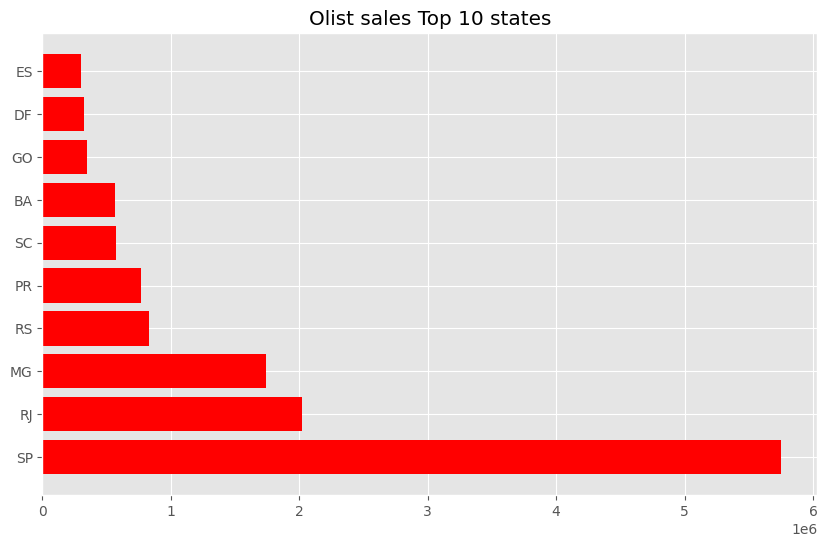

In [248]:
total_sales_customerstandard_df.head()
plt.figure(figsize=(10, 6))
plt.barh(total_sales_customerstandard_df['customer_state'],total_sales_customerstandard_df['sales'], color='red',)
plt.title('Olist sales Top 10 states')
plt.show()

In [112]:
#셀러의 매출과 도시의 상관관계
read_sql="""
SELECT 
	SUM(order_items.order_item_id * order_items.price) AS seller_sales,
    (SUM(order_items.order_item_id * order_items.price) * 100.0 / SUM(SUM(order_items.order_item_id * order_items.price)) OVER ()) AS sales_percentage,
    sellers.seller_city,
    sellers.seller_state
FROM 
order_items

LEFT JOIN
	sellers
ON
	sellers.seller_id = order_items.seller_id
    
GROUP BY
    sellers.seller_city,
    sellers.seller_state

ORDER BY
	seller_sales DESC

limit 15
"""

In [113]:
seller_sales_city_df = pd.read_sql(read_sql,conn)

/var/folders/ly/7phrswwd4gzcgyt5t5p35nqw0000gn/T/ipykernel_1326/2137120441.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  seller_sales_city_df = pd.read_sql(read_sql,conn)


In [114]:
seller_sales_city_df.set_index("seller_sales")

,sales_percentage,seller_city,seller_state
seller_sales,,,
3.136247e+06,20.368232,sao paulo,SP
7.385028e+05,4.796177,ibitinga,SP
5.164397e+05,3.353997,curitiba,PR
3.967597e+05,2.576740,rio de janeiro,RJ
3.815060e+05,2.477676,guarulhos,SP
3.400387e+05,2.208368,itaquaquecetuba,SP
3.068977e+05,1.993135,ribeirao preto,SP
2.643750e+05,1.716973,maringa,PR
2.613712e+05,1.697465,piracicaba,SP


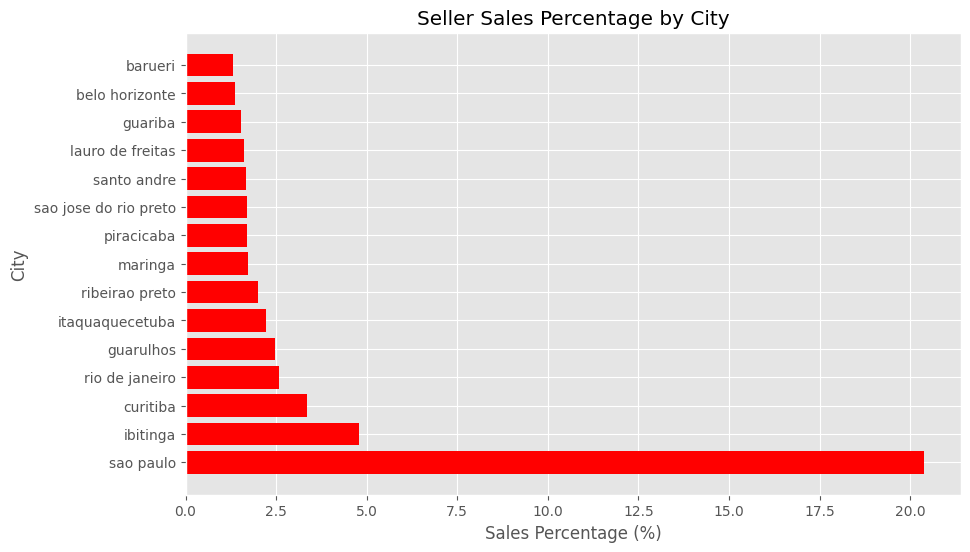

In [115]:
plt.figure(figsize=(10, 6))
plt.barh(seller_sales_city_df['seller_city'], seller_sales_city_df['sales_percentage'], color='red')
plt.xlabel('Sales Percentage (%)')
plt.ylabel('City')
plt.title('Seller Sales Percentage by City')

# 차트 표시
plt.show()


In [116]:
#셀러의 매출과 주의 상관관계
read_sql="""
SELECT 
	SUM(order_items.order_item_id * order_items.price) AS seller_sales,
    (SUM(order_items.order_item_id * order_items.price) * 100.0 / SUM(SUM(order_items.order_item_id * order_items.price)) OVER ()) AS sales_percentage,
    sellers.seller_state
FROM 
order_items

LEFT JOIN
	sellers
ON
	sellers.seller_id = order_items.seller_id
    
GROUP BY
    sellers.seller_state

ORDER BY
	seller_sales DESC

limit 15
"""

In [117]:
seller_sales_state_df = pd.read_sql(read_sql,conn)

/var/folders/ly/7phrswwd4gzcgyt5t5p35nqw0000gn/T/ipykernel_1326/3565570106.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  seller_sales_state_df = pd.read_sql(read_sql,conn)


In [118]:
seller_sales_state_df.set_index("seller_sales")

,sales_percentage,seller_state
seller_sales,,
1.001099e+07,65.015982,SP
1.422647e+06,9.239322,PR
1.151721e+06,7.479803,MG
9.110673e+05,5.916890,RJ
6.922888e+05,4.496042,SC
4.322074e+05,2.806954,RS
3.131379e+05,2.033662,BA
1.068175e+05,0.693722,DF
1.002268e+05,0.650919,PE


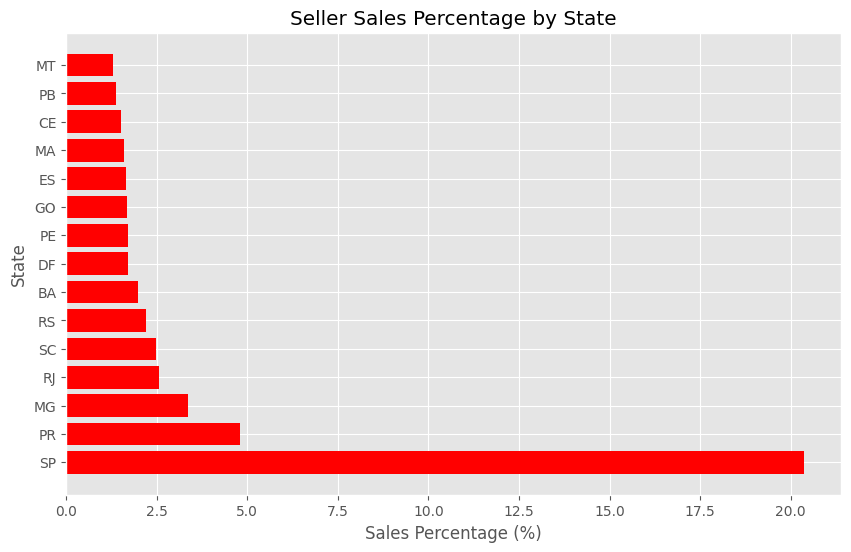

In [179]:
plt.figure(figsize=(10, 6))
plt.barh(seller_sales_state_df['seller_state'], seller_sales_city_df['sales_percentage'], color='red')
plt.xlabel('Sales Percentage (%)')
plt.ylabel('State')
plt.title('Seller Sales Percentage by State')

# 차트 표시
plt.show()

In [206]:
# 셀러와 커스터머 같은 도시에 사는 주문건수, 매출
read_sql = """
WITH onedep AS(
	SELECT 
		order_items.order_item_id,
		order_items.price,
		orders.customer_id,
		order_items.seller_id,
		orders.order_status,
        customers.customer_city
	FROM 
		orders
	LEFT JOIN
		order_items
	ON
		orders.order_id = order_items.order_id
	LEFT JOIN
		customers
	ON
		orders.customer_id = customers.customer_id
)
SELECT
	SUM(onedep.order_item_id*onedep.price) AS sales,
    count(*) AS order_amount,
	onedep.customer_city,
	s.seller_city
FROM
	onedep

    
LEFT JOIN
	sellers s
ON 
	onedep.seller_id = s.seller_id
    
WHERE
	order_status = "delivered"
    AND customer_city = seller_city

GROUP BY
	onedep.order_status,
	onedep.customer_city,
	s.seller_city

ORDER BY
    sales DESC
"""

In [207]:
snc_same_city_df = pd.read_sql(read_sql,conn)

/var/folders/ly/7phrswwd4gzcgyt5t5p35nqw0000gn/T/ipykernel_1326/2651031022.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  snc_same_city_df = pd.read_sql(read_sql,conn)


In [208]:
snc_same_city_df.set_index("sales")

,order_amount,customer_city,seller_city
sales,,,
445725.080647,4674,sao paulo,sao paulo
55642.539710,322,rio de janeiro,rio de janeiro
14912.139946,127,curitiba,curitiba
12927.979959,156,belo horizonte,belo horizonte
8754.579979,32,guarulhos,guarulhos
...,...,...,...
43.990002,1,carapicuiba,carapicuiba
42.000000,1,jaragua do sul,jaragua do sul
29.000000,1,campo limpo paulista,campo limpo paulista


In [266]:
# 셀러와 커스터머 같은 주에 사는 주문 건수, 매출 
read_sql = """
WITH onedep AS(
	SELECT 
		order_items.order_item_id,
		order_items.price,
		orders.customer_id,
		order_items.seller_id,
		orders.order_status,
        customers.customer_state
	FROM 
		orders
	LEFT JOIN
		order_items
	ON
		orders.order_id = order_items.order_id
	LEFT JOIN
		customers
	ON
		orders.customer_id = customers.customer_id
)
SELECT
	SUM(onedep.order_item_id*onedep.price) AS sales,
    count(*) AS order_amount,
	onedep.customer_state,
	s.seller_state
FROM
	onedep

    
LEFT JOIN
	sellers s
ON 
	onedep.seller_id = s.seller_id
    
WHERE
	order_status = "delivered"
    AND customer_state = seller_state
    AND seller_state = "PR"

GROUP BY
	onedep.order_status,
	onedep.customer_state,
	s.seller_state

ORDER BY
    sales DESC
"""

In [267]:
snc_same_state_df = pd.read_sql(read_sql,conn)

/var/folders/ly/7phrswwd4gzcgyt5t5p35nqw0000gn/T/ipykernel_1326/10452804.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  snc_same_state_df = pd.read_sql(read_sql,conn)


In [268]:
snc_same_state_df.set_index("sales")

,order_amount,customer_state,seller_state
sales,,,
114794.149952,805,PR,PR


In [159]:
# 셀러와 커스터머 다른 도시에 사는 주문건수, 매출
read_sql = """
WITH onedep AS(
	SELECT 
		order_items.order_item_id,
		order_items.price,
		orders.customer_id,
		order_items.seller_id,
		orders.order_status,
        customers.customer_city
	FROM 
		orders
	LEFT JOIN
		order_items
	ON
		orders.order_id = order_items.order_id
	LEFT JOIN
		customers
	ON
		orders.customer_id = customers.customer_id
)
SELECT
	SUM(onedep.order_item_id*onedep.price) AS sales,
    count(*) AS order_amount,
	onedep.customer_city,
	s.seller_city
FROM
	onedep

    
LEFT JOIN
	sellers s
ON 
	onedep.seller_id = s.seller_id
    
WHERE
	order_status = "delivered"
    AND customer_city != seller_city

GROUP BY
	onedep.order_status,
	onedep.customer_city,
	s.seller_city

ORDER BY
    sales DESC

"""

In [160]:
snc_notsame_city_df = pd.read_sql(read_sql,conn)

/var/folders/ly/7phrswwd4gzcgyt5t5p35nqw0000gn/T/ipykernel_1326/3512327077.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  snc_notsame_city_df = pd.read_sql(read_sql,conn)


In [161]:
snc_notsame_city_df.set_index("sales")

,order_amount,customer_city,seller_city
sales,,,
264357.199405,1596,rio de janeiro,sao paulo
124612.410776,1322,sao paulo,ibitinga
62369.680137,679,belo horizonte,sao paulo
62147.229882,409,sao paulo,curitiba
55175.910091,521,brasilia,sao paulo
...,...,...,...
3.000000,1,barretos,garulhos
2.990000,1,jandira,franca
1.700000,1,cotia,ibia


In [261]:
# 셀러와 커스터머 다른 주에 사는 주문 건수, 매출 
read_sql = """
WITH onedep AS(
	SELECT 
		order_items.order_item_id,
		order_items.price,
		orders.customer_id,
		order_items.seller_id,
		orders.order_status,
        customers.customer_state
	FROM 
		orders
	LEFT JOIN
		order_items
	ON
		orders.order_id = order_items.order_id
	LEFT JOIN
		customers
	ON
		orders.customer_id = customers.customer_id
)
SELECT
	SUM(onedep.order_item_id*onedep.price) AS sales,
    count(*) AS order_amount,
	onedep.customer_state,
	s.seller_state
FROM
	onedep

    
LEFT JOIN
	sellers s
ON 
	onedep.seller_id = s.seller_id
    
WHERE
	order_status = "delivered"
    AND customer_state != seller_state
    AND seller_state = "PR"

GROUP BY
	onedep.order_status,
	onedep.customer_state,
	s.seller_state

ORDER BY
    sales DESC


"""

In [262]:
snc_notsame_state_df = pd.read_sql(read_sql,conn)

/var/folders/ly/7phrswwd4gzcgyt5t5p35nqw0000gn/T/ipykernel_1326/2060578373.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  snc_notsame_state_df = pd.read_sql(read_sql,conn)


In [263]:
snc_notsame_state_df.set_index("sales")

,order_amount,customer_state,seller_state
sales,,,
515526.899503,3340,SP,PR
163460.869764,1115,RJ,PR
159657.479892,925,MG,PR
101198.529953,685,RS,PR
64950.859838,443,SC,PR
38428.540061,163,BA,PR
32752.259985,176,DF,PR
23847.689997,98,PE,PR
23495.569983,117,ES,PR


<Axes: xlabel='sales', ylabel='order_amount'>

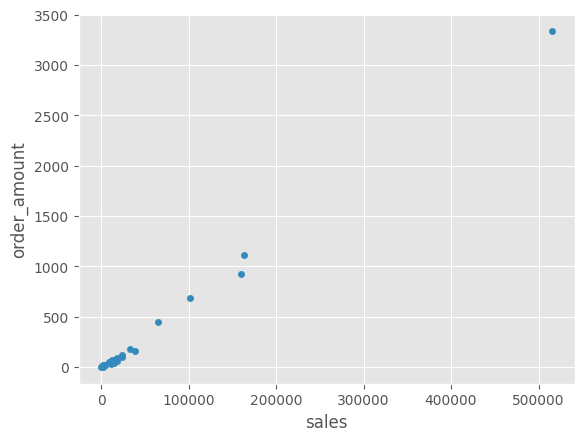

In [264]:
snc_notsame_state_df.plot(
    kind = "scatter",
    x="sales",
    y="order_amount"
    
)

<Axes: xlabel='sales', ylabel='order_amount'>

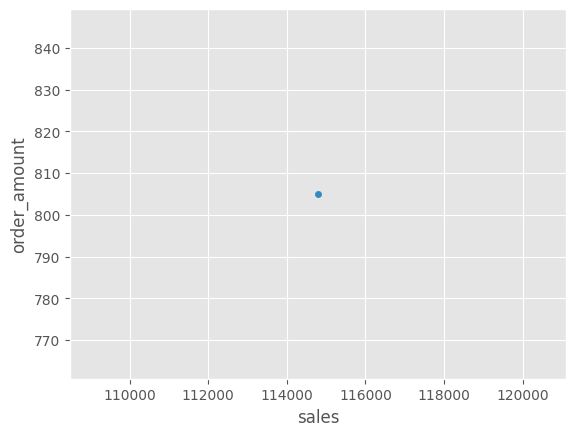

In [269]:
snc_same_state_df.plot(
    kind = "scatter",
    x="sales",
    y="order_amount"
    
)

<Axes: xlabel='sales', ylabel='order_amount'>

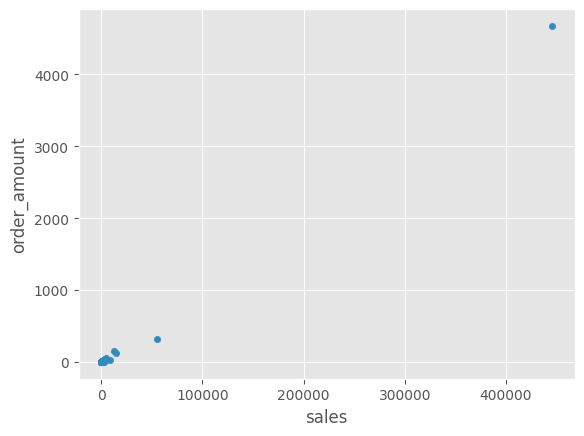

In [213]:
snc_same_city_df.plot(
    kind = "scatter",
    x="sales",
    y="order_amount"
    
)

<Axes: xlabel='sales', ylabel='order_amount'>

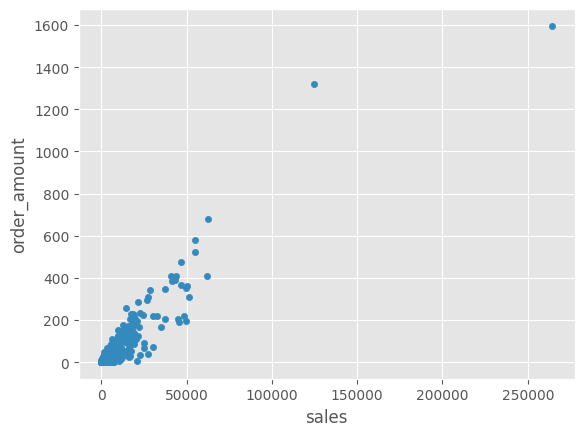

In [214]:
snc_notsame_city_df.plot(
    kind = "scatter",
    x="sales",
    y="order_amount"
    
)

In [290]:
# 셀러와 커스터머 같은 주에 사는 경우 쉬핑 이후 평균 배송기간, 전체 주문 수 , 전체 배송 중 지연률
read_sql = """
WITH onedep AS(
	SELECT 
		datediff(orders.order_delivered_customer_date,orders.order_delivered_carrier_date) AS carrier_delivery_duration,
        orders.order_delivered_carrier_date,
        orders.order_delivered_customer_date,
        orders.order_estimated_delivery_date,
		orders.customer_id,
		order_items.seller_id,
		orders.order_status,
        customers.customer_city,
        customers.customer_state
	FROM 
		orders
	LEFT JOIN
		order_items
	ON
		orders.order_id = order_items.order_id
	LEFT JOIN
		customers
	ON
		orders.customer_id = customers.customer_id
)
SELECT
    AVG(onedep.carrier_delivery_duration) AS avg_carrier_delivery_duration,
    COUNT(*) AS total_orders,
    SUM(CASE WHEN onedep.order_delivered_customer_date > onedep.order_estimated_delivery_date THEN 1 ELSE 0 END) / COUNT(*) AS delay_rate,
    s.seller_state,
    onedep.customer_state
FROM
    onedep
LEFT JOIN
    sellers s
ON 
    onedep.seller_id = s.seller_id
WHERE
    onedep.order_status = 'delivered'
    AND onedep.customer_state = s.seller_state
GROUP BY
    onedep.customer_state,
    s.seller_state
    
ORDER BY
    total_orders DESC
    
LIMIT 10
"""

In [291]:
delivery_score_same_state_df = pd.read_sql(read_sql,conn)

/var/folders/ly/7phrswwd4gzcgyt5t5p35nqw0000gn/T/ipykernel_1326/2232505485.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  delivery_score_same_state_df = pd.read_sql(read_sql,conn)


In [293]:
delivery_score_same_state_df.set_index("avg_carrier_delivery_duration")

,total_orders,delay_rate,seller_state,customer_state
avg_carrier_delivery_duration,,,,
4.6977,35425,0.0610,SP,SP
5.5003,1669,0.0306,MG,MG
3.6208,1084,0.0618,RJ,RJ
4.7590,805,0.0435,PR,PR
3.9283,321,0.0685,RS,RS
5.1913,298,0.0705,SC,SC
6.9054,74,0.0946,BA,BA
1.7377,61,0.0984,DF,DF
3.4872,39,0.0769,GO,GO


In [358]:
# 셀러와 커스터머 다른 주에 사는 경우 쉬핑 이후 평균 배송기간, 전체 주문 수 , 전체 배송 중 지연률
read_sql = """
WITH onedep AS(
	SELECT 
		datediff(orders.order_delivered_customer_date,orders.order_delivered_carrier_date) AS carrier_delivery_duration,
        orders.order_delivered_carrier_date,
        orders.order_delivered_customer_date,
        orders.order_estimated_delivery_date,
		orders.customer_id,
		order_items.seller_id,
		orders.order_status,
        customers.customer_city,
        customers.customer_state
	FROM 
		orders
	LEFT JOIN
		order_items
	ON
		orders.order_id = order_items.order_id
	LEFT JOIN
		customers
	ON
		orders.customer_id = customers.customer_id
)
SELECT
    AVG(onedep.carrier_delivery_duration) AS avg_carrier_delivery_duration,
    COUNT(*) AS total_orders,
    SUM(CASE WHEN onedep.order_delivered_customer_date > onedep.order_estimated_delivery_date THEN 1 ELSE 0 END) / COUNT(*) AS delay_rate,
    s.seller_state,
    onedep.customer_state

FROM
    onedep
LEFT JOIN
    sellers s
ON 
    onedep.seller_id = s.seller_id
WHERE
    onedep.order_status = 'delivered'
    AND onedep.customer_state != s.seller_state
    AND onedep.customer_state = 'SP'
    
GROUP BY
    onedep.customer_state,
    s.seller_state
    
ORDER BY
    total_orders DESC
    
LIMIT 10
"""

In [359]:
delivery_score_notsame_state_sp_df  = pd.read_sql(read_sql,conn)

/var/folders/ly/7phrswwd4gzcgyt5t5p35nqw0000gn/T/ipykernel_1326/2395325866.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  delivery_score_notsame_state_sp_df  = pd.read_sql(read_sql,conn)


In [360]:
delivery_score_notsame_state_sp_df.set_index("avg_carrier_delivery_duration")

,total_orders,delay_rate,seller_state,customer_state
avg_carrier_delivery_duration,,,,
7.5439,3340,0.0365,PR,SP
7.6238,2902,0.0407,MG,SP
8.8265,1487,0.0410,SC,SP
8.7898,1470,0.0850,RJ,SP
6.8732,749,0.0214,RS,SP
7.7295,329,0.0274,DF,SP
8.4533,150,0.0533,BA,SP
8.2920,137,0.0365,GO,SP
10.4538,130,0.2692,MA,SP


In [15]:
# 특정 지역고객이 많은 이유는 뭘까? 어떤 부분에서 강점이 있는 걸까?
# 구매를 자주하는 고객 정보 분석해보기
# 1. 특히 배송이 다른 지역보다 빠른가? 셀러들의 지역분포와 배송속도 연관성 찾아보기
# 2. 배송이 빠르면 리뷰 평점이 실제로 좋을까? 

In [256]:
# 1. 쉬핑되고나서 고객에게 배송완료 된 기간이 7일이 넘지않는 제품카테고리

read_sql="""
SELECT 
	AVG(datediff(orders.order_delivered_customer_date,orders.order_delivered_carrier_date)) AS carrier_delivery_duration,
    products.product_category_name
FROM 
	orders
LEFT JOIN
	order_items
ON 
	orders.order_id = order_items.order_id
LEFT JOIN
	products
ON
	order_items.product_id=products.product_id

WHERE
	order_status = "delivered"
    AND datediff(orders.order_delivered_customer_date,orders.order_delivered_carrier_date) < 7
    AND products.deleted = false

GROUP BY
	products.product_category_name

ORDER BY
    carrier_delivery_duration
"""

In [257]:
result_df = pd.read_sql(read_sql,conn)

/var/folders/ly/7phrswwd4gzcgyt5t5p35nqw0000gn/T/ipykernel_49079/4254694705.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result_df = pd.read_sql(read_sql,conn)


In [258]:
under7days_delivery_cate_df = result_df.set_index("product_category_name")

Text(0, 0.5, 'Days')

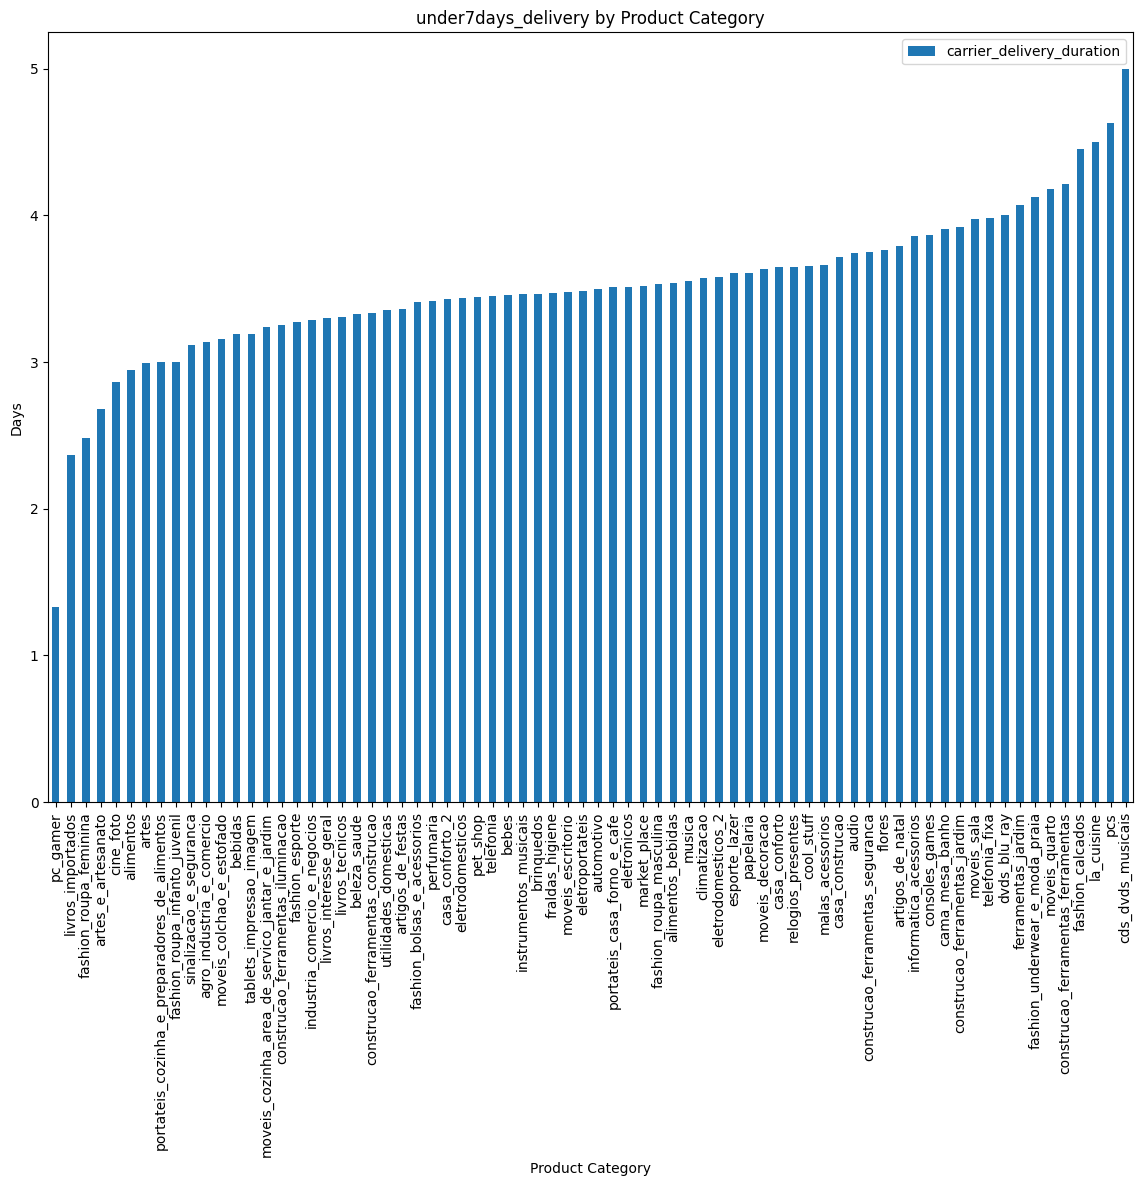

In [259]:
under7days_delivery_cate_df.plot(kind="bar",figsize=(14, 10))
plt.plot()
plt.title('under7days_delivery by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Days')

In [260]:
# 2. 쉬핑되고나서 고객에게 배송완료 된 기간이 7일 초과 14일미만 제품카테고리
read_sql="""
SELECT 
	AVG(datediff(orders.order_delivered_customer_date,orders.order_delivered_carrier_date)) AS carrier_delivery_duration,
-- 	order_delivered_carrier_date,
--     order_delivered_customer_date,
--     order_estimated_delivery_date,
    products.product_category_name
FROM 
	orders
LEFT JOIN
	order_items
ON 
	orders.order_id = order_items.order_id
LEFT JOIN
	products
ON
	order_items.product_id=products.product_id

WHERE
	order_status = "delivered"
    AND datediff(orders.order_delivered_customer_date,orders.order_delivered_carrier_date) > 7
    AND datediff(orders.order_delivered_customer_date,orders.order_delivered_carrier_date) < 14
    AND products.deleted = false

GROUP BY
	products.product_category_name

ORDER BY
	carrier_delivery_duration
"""

In [261]:
result_df = pd.read_sql(read_sql,conn)

/var/folders/ly/7phrswwd4gzcgyt5t5p35nqw0000gn/T/ipykernel_49079/4254694705.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result_df = pd.read_sql(read_sql,conn)


In [262]:
under14days_delivery_cate_df = result_df.set_index("product_category_name")

Text(0, 0.5, 'Days')

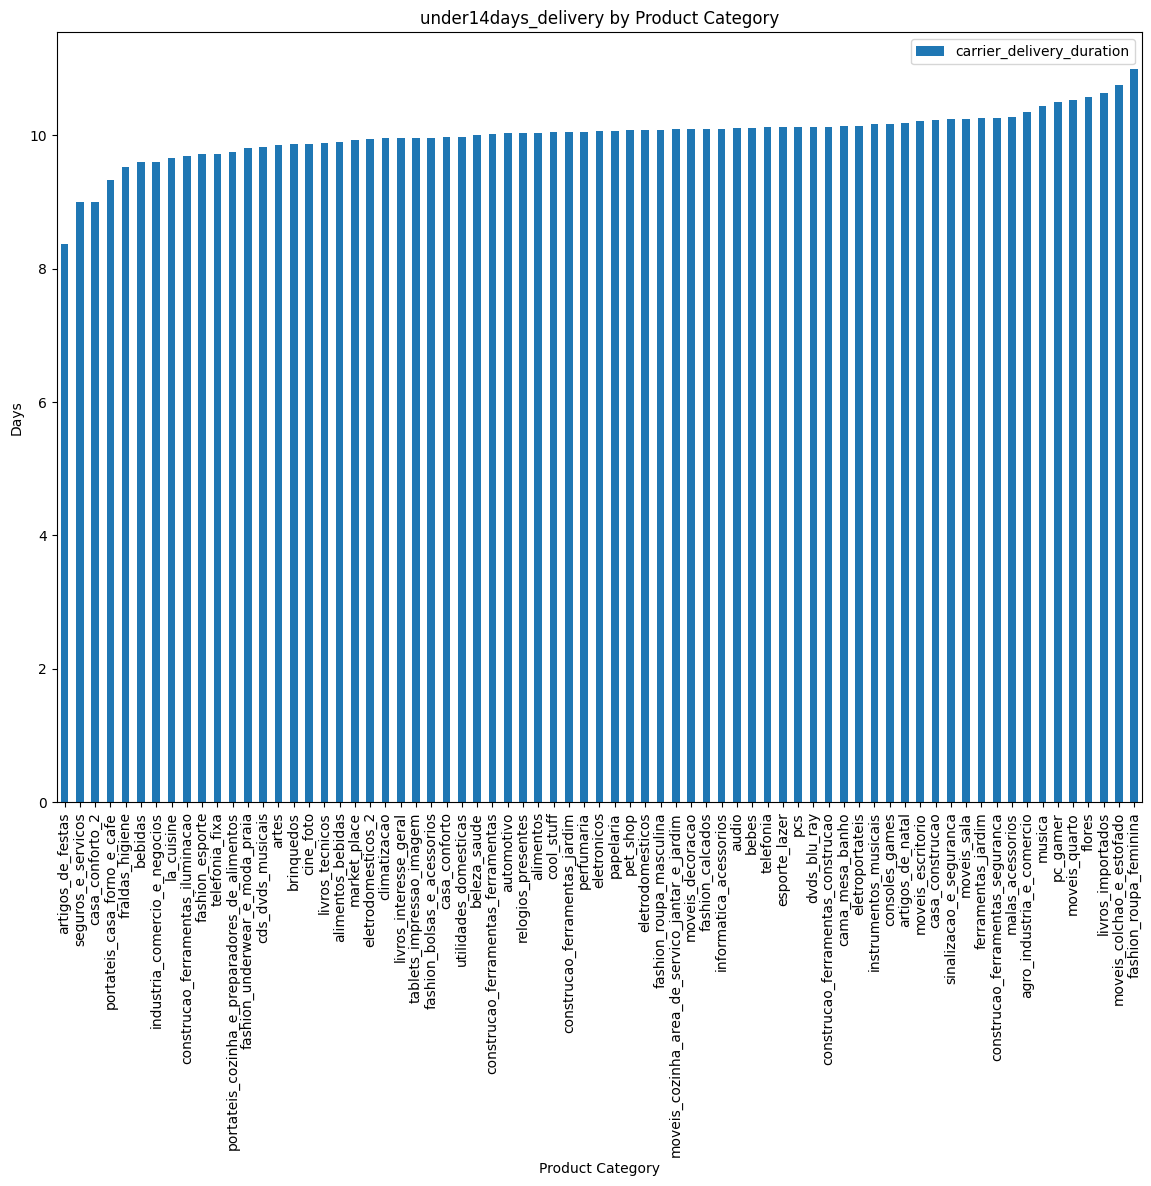

In [269]:
under14days_delivery_cate_df.plot(kind="bar",figsize=(14, 10))
plt.title('under14days_delivery by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Days')

In [264]:
# 15일 이상 걸린 카테고리
read_sql = """
SELECT 
	AVG(datediff(orders.order_delivered_customer_date,orders.order_delivered_carrier_date)) AS carrier_delivery_duration,
-- 	order_delivered_carrier_date,
--     order_delivered_customer_date,
--     order_estimated_delivery_date,
    products.product_category_name
FROM 
	orders
LEFT JOIN
	order_items
ON 
	orders.order_id = order_items.order_id
LEFT JOIN
	products
ON
	order_items.product_id=products.product_id

WHERE
	order_status = "delivered"
    AND datediff(orders.order_delivered_customer_date,orders.order_delivered_carrier_date) > 15
    AND products.deleted = false

GROUP BY
	products.product_category_name

ORDER BY
	carrier_delivery_duration
"""

In [265]:
result_df = pd.read_sql(read_sql,conn)

/var/folders/ly/7phrswwd4gzcgyt5t5p35nqw0000gn/T/ipykernel_49079/4254694705.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result_df = pd.read_sql(read_sql,conn)


In [266]:
over15days_delivery_cate_df = result_df.set_index("product_category_name")

Text(0, 0.5, 'Days')

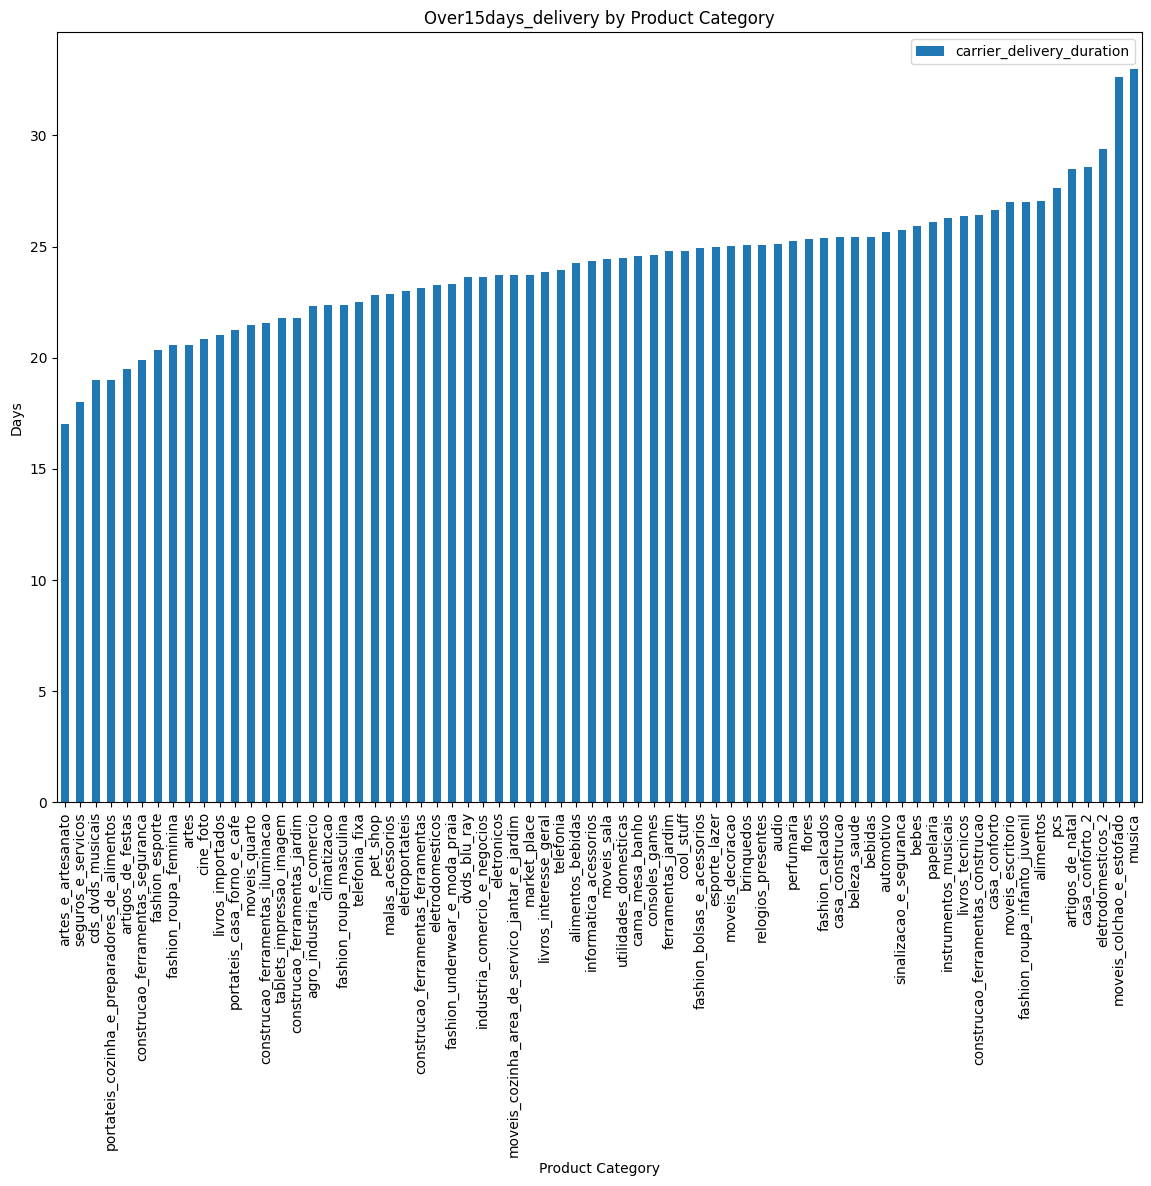

In [268]:
over15days_delivery_cate_df.plot(kind="bar",figsize=(14, 10))
plt.title('Over15days_delivery by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Days')

In [204]:
 # 예상도착시간이 7일 이상 걸리는 제품의 카테고리
 # 현 물류 파트너의 퍼포먼스 수치 / 배송시간 seller지역과 같은 주에 사는 고객에게 배송되는 medien 시간
 # - seller와 customer 같은지역 주문 건수 중 5.98% 가 도착예상시간보다 늦게 도착했다. 
 # seller지역과 다른 주에 사는 고객에게 배송되는 medien 시간
 # 배송기간이 구매, 매출에 미치는 영향력?
read_sql= """
WITH order_info_c AS (
SELECT 
	orders.order_status,
    orders.order_purchase_timestamp,
    orders.order_delivered_carrier_date,
    orders.order_delivered_customer_date,
    orders.order_estimated_delivery_date,
    order_items.seller_id,
    customers.customer_city,
    customers.customer_state
FROM 
	orders
LEFT JOIN
	order_items
ON 
	orders.order_id = order_items.order_id
LEFT JOIN
	customers
ON
	orders.customer_id = customers.customer_id
)
SELECT
*
FROM
	order_info_c
LEFT JOIN
	sellers
ON
	order_info_c.seller_id = sellers.seller_id
    
WHERE
	order_status = "delivered"
    AND sellers.seller_state = order_info_c.customer_state
    AND order_info_c.order_estimated_delievery_date > order_info_c.order_delivered_customer_date
"""

In [205]:
result_df = pd.read_sql(read_sql,conn)

/var/folders/ly/7phrswwd4gzcgyt5t5p35nqw0000gn/T/ipykernel_49079/4254694705.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result_df = pd.read_sql(read_sql,conn)


DatabaseError: Execution failed on sql '
WITH order_info_c AS (
SELECT 
	orders.order_status,
   orders.order_purchase_timestamp,
   orders.order_delivered_carrier_date,
   orders.order_delivered_customer_date,
   orders.order_estimated_delivery_date,
   order_items.seller_id,
   customers.customer_city,
   customers.customer_state
FROM 
	orders
LEFT JOIN
	order_items
ON 
	orders.order_id = order_items.order_id
LEFT JOIN
	customers
ON
	orders.customer_id = customers.customer_id
)
SELECT
*
FROM
	order_info_c
LEFT JOIN
	sellers
ON
	order_info_c.seller_id = sellers.seller_id
   
WHERE
	order_status = "delivered"
   AND sellers.seller_state = order_info_c.customer_state
   AND order_info_c.order_estimated_delievery_date > order_info_c.order_delivered_customer_date
': (1054, "Unknown column 'order_info_c.order_estimated_delievery_date' in 'where clause'")

In [201]:
result_df

,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,seller_id,customer_city,customer_state,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,delivered,2017-04-26 10:53:06,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,dd7ddc04e1b6c2c614352b383efe2d36,santa fe do sul,SP,dd7ddc04e1b6c2c614352b383efe2d36,03471,sao paulo,SP
1,delivered,2018-01-14 14:33:31,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,5b51032eddd242adc84c38acab88f23d,para de minas,MG,5b51032eddd242adc84c38acab88f23d,37564,borda da mata,MG
2,delivered,2018-08-08 10:00:35,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,9d7a1d34a5052409006425275ba1c2b4,atibaia,SP,9d7a1d34a5052409006425275ba1c2b4,14403,franca,SP
3,delivered,2017-12-10 11:53:48,2017-12-12 01:07:48,2017-12-18 22:03:38,2018-01-04,7040e82f899a04d1b434b795a43b4617,guararapes,SP,7040e82f899a04d1b434b795a43b4617,01026,sao paulo,SP
4,delivered,2018-07-04 12:08:27,2018-07-05 12:15:00,2018-07-09 14:04:07,2018-07-25,5996cddab893a4652a15592fb58ab8db,praia grande,SP,5996cddab893a4652a15592fb58ab8db,19010,presidente prudente,SP
...,...,...,...,...,...,...,...,...,...,...,...,...
39861,delivered,2017-09-25 22:41:26,2017-09-27 12:59:49,2017-09-28 22:38:04,2017-10-10,058cb5aeb36d7c0fcae20fc85d5e0a59,rio de janeiro,RJ,058cb5aeb36d7c0fcae20fc85d5e0a59,21635,rio de janeiro,RJ
39862,delivered,2017-11-24 09:03:47,2017-11-27 22:44:45,2017-11-29 02:24:25,2017-12-08,bd23da7354813347129d751591d1a6e2,sao paulo,SP,bd23da7354813347129d751591d1a6e2,03971,sao paulo,SP
39863,delivered,2017-04-12 16:35:43,2017-04-27 09:26:54,2017-05-17 11:38:22,2017-05-15,36a968b544695394e4e9d7572688598f,campinas,SP,36a968b544695394e4e9d7572688598f,11010,santos,SP
39864,delivered,2017-08-14 23:02:59,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25,2b3e4a2a3ea8e01938cabda2a3e5cc79,vinhedo,SP,2b3e4a2a3ea8e01938cabda2a3e5cc79,04733,sao paulo,SP


In [ ]:
# 가장 매출이 많았던 날 - 일자별 매출
# RESULTS
# SUM(price), year_month_day
# '26880', '2017-10-06'
# '14517.760005950928', '2018-07-23'
# '13470', '2017-02-16'


"""
SELECT SUM(price),
	DATE_FORMAT(shipping_limit_data, '%Y-%m-%d') AS year_month_day
FROM Data_analysis.order_items
    
GROUP BY
	shipping_limit_data
ORDER BY
	SUM(price) DESC
"""

In [ ]:
# 2017년 10월 6일 특정일자에 매출이 유달리 높다. 월별 평균 매출을 확인하고 , 10월이 다른 달보다 높은지 확인해보자.

In [12]:
def read_query(read_sql):
    with conn.cursor() as cursor:
        cursor.execute(read_sql)
        result = cursor.fetchall()
    return result
    
read_sql = sql = """
SELECT
    *
FROM
    orders
"""

result = read_query(read_sql)


In [ ]:
"""
WITH one_step AS (
SELECT 
	p.product_id,
    p.product_category_name,
    o.order_id
FROM
	products p
LEFT JOIN
	order_items o
ON
	p.product_id=o.product_id
)
SELECT
	AVG(review_score),
    one_step.product_category_name
FROM
	reviews
LEFT JOIN
	one_step
ON
	reviews.order_id=one_step.order_id
GROUP BY
	one_step.product_category_name
"""